### LSTM

In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
file_path = 'dsets\group_num\group_5565.csv'
data = pd.read_csv(file_path)

# 타임스탬프 컬럼을 datetime 형식으로 변환
data['tm'] = pd.to_datetime(data['tm'])

features = ['hh24', 'sum_qctr', 'n', 'sum_load', 'nph_ta', 'nph_hm', 'nph_rn_60m', 'elec']
data = data[features + ['weekday']]

print(data.head(5))

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# 스케일링된 데이터를 DataFrame으로 변환하여 weekday 정보 추가
scaled_data = pd.DataFrame(scaled_data, columns=features)
scaled_data['weekday'] = data['weekday'].values

print(scaled_data.head(5))


   hh24  sum_qctr   n  sum_load  nph_ta  nph_hm  nph_rn_60m   elec  weekday
0     1     42250  58   4468.72     2.3    65.8         0.0  96.58        2
1     2     42250  58   4101.00     2.5    69.7         0.0  88.63        2
2     3     42250  58   3724.60     2.8    69.5         0.0  80.50        2
3     4     42250  58   3484.40     2.8    66.0         0.0  75.31        2
4     5     42250  58   3409.12     3.0    66.1         0.0  73.68        2
       hh24  sum_qctr    n  sum_load    nph_ta    nph_hm  nph_rn_60m  \
0  0.000000       1.0  1.0  0.341115  0.129288  0.581998         0.0   
1  0.043478       1.0  1.0  0.293362  0.134565  0.630086         0.0   
2  0.086957       1.0  1.0  0.244482  0.142480  0.627620         0.0   
3  0.130435       1.0  1.0  0.213289  0.142480  0.584464         0.0   
4  0.173913       1.0  1.0  0.203514  0.147757  0.585697         0.0   

       elec  weekday  
0  0.230114        2  
1  0.178451        2  
2  0.125617        2  
3  0.091890        

In [89]:
# 주간 시퀀스 생성 함수
def create_weekly_sequences(data, target_column, sequence_length=7*24):
    sequences = []
    targets = []
    
    # 일별 데이터 그룹화
    for i in range(0, len(data) - sequence_length + 1, 24):
        week_data = data[i:i + sequence_length]
        if len(week_data) == sequence_length:
            sequences.append(week_data.drop(columns=[target_column]).values)
            targets.append(week_data[target_column].values.reshape(-1,1))  # 마지막 날의 target 값 사용
    
    return np.array(sequences), np.array(targets)


# 주간 시퀀스 생성
weekly_sequences, targets = create_weekly_sequences(scaled_data, 'elec')

# 시퀀스 데이터 확인
print("Weekly sequences shape:", weekly_sequences.shape)
print("Targets shape:", targets.shape)


Weekly sequences shape: (1090, 168, 8)
Targets shape: (1090, 168, 1)


weekly_sequences는 (n,m,k)의 형태로, 격자 5565 기준 (1090, 168, 8)의 shape을 보입니다.
k는 학습에 포함시키기 위해 지정한 feature의 수이고, m은 7*24로 weekday=0~6의 24시간을 한 시퀀스로 묶어 학습하기 위해 설정한 것입니다.

### Train

In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

Epoch 1/50
22/22 [==============================] - 3s 67ms/step - loss: 0.1100 - val_loss: 0.0300
Epoch 2/50
22/22 [==============================] - 1s 46ms/step - loss: 0.0276 - val_loss: 0.0207
Epoch 3/50
22/22 [==============================] - 1s 46ms/step - loss: 0.0198 - val_loss: 0.0158
Epoch 4/50
22/22 [==============================] - 1s 45ms/step - loss: 0.0150 - val_loss: 0.0126
Epoch 5/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0117 - val_loss: 0.0097
Epoch 6/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 7/50
22/22 [==============================] - 1s 45ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 8/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 11/

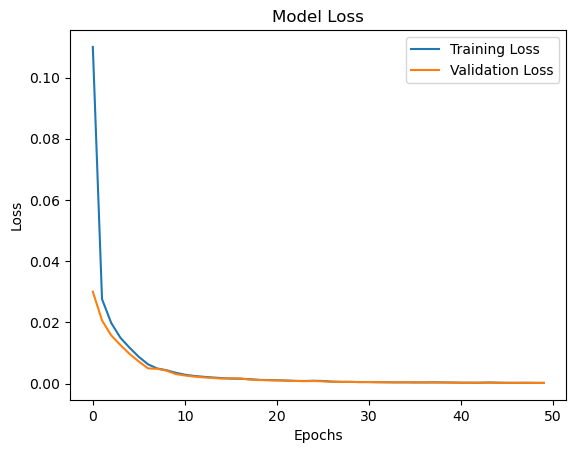

In [91]:
# 데이터를 LSTM 입력 형식으로 변환
X = weekly_sequences
y = targets

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# 모델 저장
model.save('lstm_5565.h5')

# 손실 값 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [92]:
print(X_test.shape)
print(y_test.shape)

(218, 168, 8)
(218, 168, 1)


In [100]:
# 모델 로드
model = load_model('lstm_5565.h5')

# 테스트 데이터 예측
y_pred = model.predict(X_test)

y_test_flat = y_test.reshape(-1, 1)
y_pred_flat = y_pred.reshape(-1, 1)
y_pred_flat = scaler.inverse_transform(y_pred_flat)
y_test_flat = scaler.inverse_transform(y_test_flat)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Actual')
plt.plot(y_pred_flat, label='Predicted')
plt.title('Actual vs Predicted Electricity Consumption')
plt.xlabel('Samples')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()

# 성능 평가
mse = mean_squared_error(y_test_flat, y_pred_flat)
print(f'Mean Squared Error: {mse}')

7/7 [==============================] - 0s 14ms/step


ValueError: non-broadcastable output operand with shape (36624,1) doesn't match the broadcast shape (36624,8)

In [98]:
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 모델 로드
model = load_model('lstm_5565.h5')

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 예측 결과 역스케일링
# 예측 값의 형태를 (num_samples * timesteps, 1)로 변환
y_pred_reshaped = y_pred.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# 원래 데이터의 스케일로 역변환하기 위해 전체 데이터의 형태를 맞춤
dummy_data = np.zeros((y_pred_reshaped.shape[0], scaled_data.shape[1]))
dummy_data[:, -1] = y_pred_reshaped[:, 0]
y_pred_inverse = scaler.inverse_transform(dummy_data)[:, -1]

dummy_data[:, -1] = y_test_reshaped[:, 0]
y_test_inverse = scaler.inverse_transform(dummy_data)[:, -1]

# 예측 결과를 평탄화
y_test_flat = y_test_inverse.flatten()
y_pred_flat = y_pred_inverse.flatten()

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Actual')
plt.plot(y_pred_flat, label='Predicted')
plt.title('Actual vs Predicted Electricity Consumption')
plt.xlabel('Samples')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()

# 성능 평가
mse = mean_squared_error(y_test_flat, y_pred_flat)
print(f'Mean Squared Error: {mse}')


7/7 [==============================] - 0s 14ms/step


ValueError: operands could not be broadcast together with shapes (36624,9) (8,) (36624,9) 